In [1]:
%cd ..

d:\github\ripple_heterogeneity\python


In [2]:
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import hdf5storage
import h5py
import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\project_log'

In [4]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = event.n_events/ripple_epochs[i].length
    return unit_mat

def pairwise_cross_corr(spks, binsize = 0.001, nbins = 100):
    # Get unique combo without repeats
    x = np.arange(0,spks.shape[0])
    c = np.array(list(itertools.combinations(x, 2)))
    # prepare a pandas dataframe to receive the data
    times = np.arange(0, binsize*(nbins+1), binsize) - (nbins*binsize)/2	
    crosscorrs = pd.DataFrame(index = times,columns = np.arange(len(c)))

    # Now we can iterate over spikes
    for i,s in enumerate(c):	
        # Calling the crossCorr function
        crosscorrs[i] = functions.crossCorr(spks[s[0]], spks[s[1]], binsize, nbins)
    return crosscorrs

def pairwise_corr(unit_mat):
    x = np.arange(0,unit_mat.shape[0])
    c = np.array(list(itertools.combinations(x, 2)))
    rho = []
    pval = []
    for i,s in enumerate(c):	
        rho_, pval_ = stats.spearmanr(unit_mat[s[0],:], unit_mat[s[1],:])
        rho.append(rho_)
        pval.append(pval_)
    return rho,pval,c

def main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs):

    # create empty dataframe to add metrics from each epoch
    df_save = pd.DataFrame()

    # restrict to ripples
    st_unit_rip = st_unit[ripple_epochs]

    # general epochs to iter through, this can be replaced with the 
    #   actual epoch names if runing on many datasets
    epochs = ['pre','task','post']

    for i in range(len(epochs)):

        # get a firing rate matrix [n cells x n ripples]
        unit_mat = get_participation(st_unit_rip[behavioral_epochs[i]],
                                        ripple_epochs[behavioral_epochs[i]])

        # get unique pairwise correlations 
        rho,pval,c = pairwise_corr(unit_mat)

        temp_df = pd.DataFrame()
        temp_df['ref'] = c[:,0]
        temp_df['target'] = c[:,1]
        temp_df['UID_ref'] = cell_metrics.UID.iloc[temp_df['ref']].values
        temp_df['UID_target'] = cell_metrics.UID.iloc[temp_df['target']].values
        temp_df['rho'] = rho
        temp_df['pval'] = pval
        temp_df['deepSuperficial_ref'] = cell_metrics.deepSuperficial.iloc[temp_df['ref']].values
        temp_df['deepSuperficial_target'] = cell_metrics.deepSuperficial.iloc[temp_df['target']].values
        temp_df['epoch'] = epochs[i]
        temp_df['basepath'] = basepath

        df_save = df_save.append(temp_df,ignore_index=True)

    return df_save

def session_loop(basepath,save_path):
    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.csv')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")))

    # restrict cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]

    # get ripple epochs
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

    # behavioral epochs
    behavioral_epochs = nel.EpochArray([np.array([data['epochs'].startTime,
                                                    data['epochs'].stopTime]).T])

    df_save = main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs)
    df_save.to_csv(save_file)

def ripple_corr_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            print(basepath)
            session_loop(basepath,save_path)    

In [5]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_corr'

# get grosmark sessions
df = df.loc[df['basepath'].str.contains("grosmark", case=False)]

ripple_corr_run(df,save_path,parallel=True)

In [6]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        results = results.append(df1,ignore_index=True)
    return results

df = load_in_everything(save_path)
df

,Unnamed: 0,ref,target,UID_ref,UID_target,rho,pval,deepSuperficial_ref,deepSuperficial_target,epoch,basepath
0,0,0,1,1,3,0.019271,0.181780,Deep,Deep,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
1,1,0,2,1,4,-0.003608,0.802574,Deep,Deep,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
2,2,0,3,1,7,0.007846,0.586688,Deep,Deep,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
3,3,0,4,1,9,-0.032501,0.024294,Deep,Deep,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
4,4,0,5,1,10,0.013319,0.356082,Deep,Deep,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
...,...,...,...,...,...,...,...,...,...,...,...
103357,2455,37,39,43,45,-0.010969,0.394559,Deep,Deep,post,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013
103358,2456,37,40,43,46,0.014870,0.248391,Deep,Deep,post,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013
103359,2457,38,39,44,45,0.021058,0.102116,Deep,Deep,post,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013
103360,2458,38,40,44,46,0.031599,0.014157,Deep,Deep,post,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013


Text(0.5, 0, 'post')

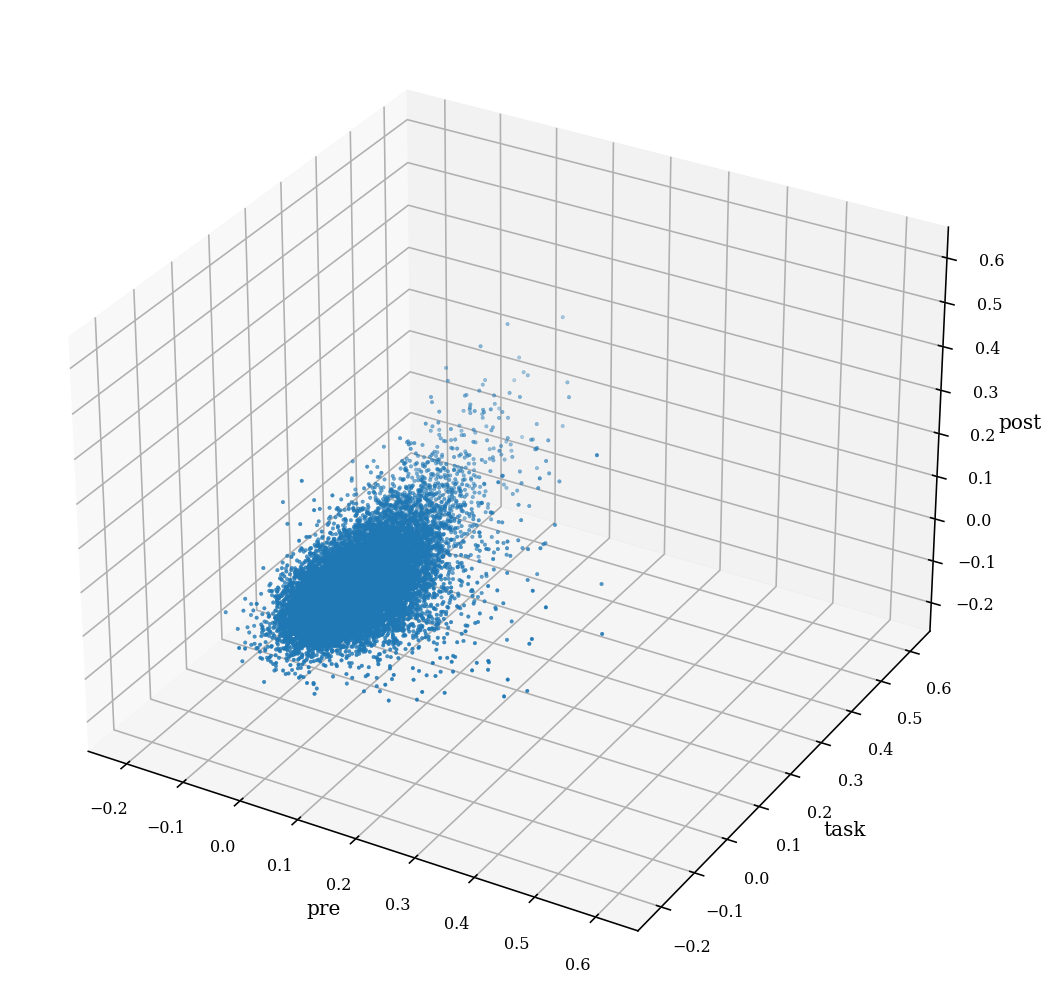

In [7]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')

ax.scatter(df[(df.epoch == "pre")].rho,df[(df.epoch == "task")].rho,df[(df.epoch == "post")].rho,s=3)
# ax.axhline(0,color="r")
# ax.plot([0,0],[-.25,.65],[0,0],color="r")

ax.set_xlim(-.25,.65)
ax.set_ylim(-.25,.65)
ax.set_zlim(-.25,.65)

ax.set_xlabel('pre')
ax.set_ylabel('task')
ax.set_zlabel('post')

# Deep Sup analysis

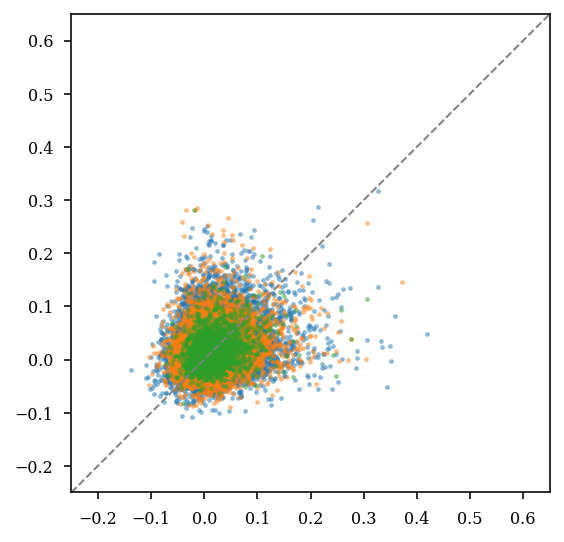

In [24]:
epoch2 = "post"
idx = (df.deepSuperficial_ref == "Deep") & (df.deepSuperficial_target == "Deep")
plt.scatter(df[(df.epoch == "pre") & idx].rho,df[(df.epoch == epoch2) & idx].rho,s=4,alpha=.5 )

idx = (
    ((df.deepSuperficial_ref == "Deep") & (df.deepSuperficial_target == "Superficial")) |
     ((df.deepSuperficial_ref == "Superficial") & (df.deepSuperficial_target == "Deep"))
    )
plt.scatter(df[(df.epoch == "pre") & idx].rho,df[(df.epoch == epoch2) & idx].rho,s=4,alpha=.5 )

idx = (df.deepSuperficial_ref == "Superficial") & (df.deepSuperficial_target == "Superficial")
plt.scatter(df[(df.epoch == "pre") & idx].rho,df[(df.epoch == epoch2) & idx].rho,s=4,alpha=.5 )


plt.xlim(-.25,.65)
plt.ylim(-.25,.65)
ax = plt.gca()
ax.set_aspect('equal')
ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='grey',ls='--',linewidth=1)


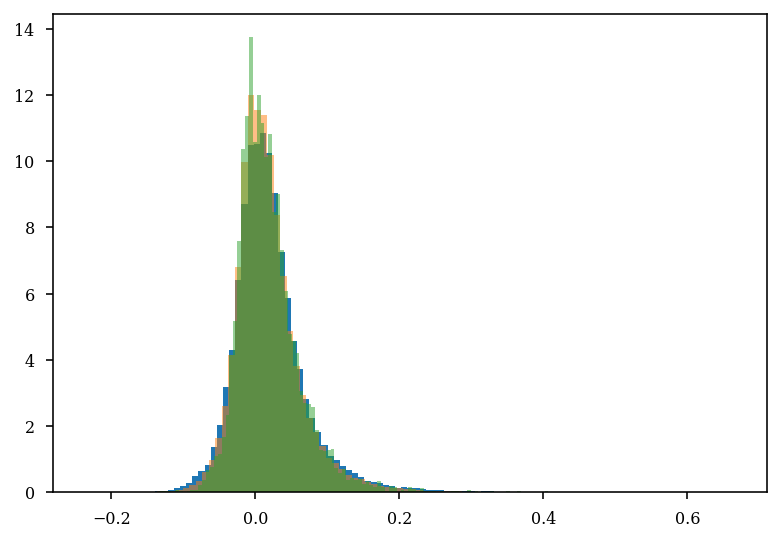

In [9]:
plt.hist(df.rho[(df.deepSuperficial_ref=="Deep") & (df.deepSuperficial_target=="Deep")],100,density=True)
idx = (
    ((df.deepSuperficial_ref=="Deep") &
        (df.deepSuperficial_target=="Superficial")) |
    ((df.deepSuperficial_ref=="Superficial") &
        (df.deepSuperficial_target=="Deep"))
    )
plt.hist(df.rho[idx],100,density=True,alpha=.5)
plt.hist(df.rho[(df.deepSuperficial_ref=="Superficial") & (df.deepSuperficial_target=="Superficial")],100,density=True,alpha=.5)

plt.show()

# plt.plot(rho,pval,'.k')
# plt.xscale("log")
# plt.yscale("log")


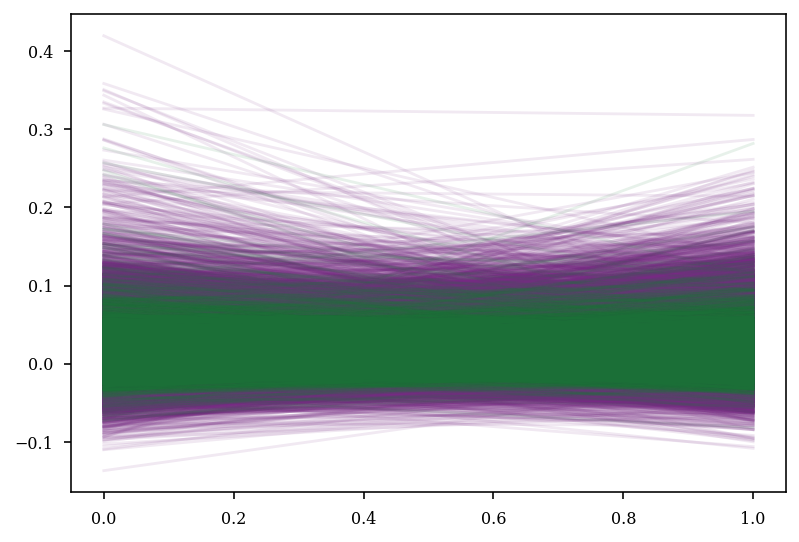

In [34]:
group_colors = {"deep": '#762a83',
                'sup': '#1b7837'} 

idx = (df.deepSuperficial_ref == "Deep") & (df.deepSuperficial_target == "Deep")
plt.plot(np.array([df[(df.epoch == "pre") & idx].rho.values,df[(df.epoch == epoch2) & idx].rho.values]),color="#762a83",alpha=.1)

idx = (df.deepSuperficial_ref == "Superficial") & (df.deepSuperficial_target == "Superficial")
plt.plot(np.array([df[(df.epoch == "pre") & idx].rho.values,df[(df.epoch == epoch2) & idx].rho.values]),color="#1b7837",alpha=.1)


plt.show()


In [33]:

df['deepSuperficial_combo'] = df['deepSuperficial_ref']+df['deepSuperficial_target']
df

,Unnamed: 0,ref,target,UID_ref,UID_target,rho,pval,deepSuperficial_ref,deepSuperficial_target,epoch,basepath,deepSuperficial_combo
0,0,0,1,1,3,0.019271,0.181780,Deep,Deep,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,DeepDeep
1,1,0,2,1,4,-0.003608,0.802574,Deep,Deep,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,DeepDeep
2,2,0,3,1,7,0.007846,0.586688,Deep,Deep,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,DeepDeep
3,3,0,4,1,9,-0.032501,0.024294,Deep,Deep,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,DeepDeep
4,4,0,5,1,10,0.013319,0.356082,Deep,Deep,pre,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,DeepDeep
...,...,...,...,...,...,...,...,...,...,...,...,...
103357,2455,37,39,43,45,-0.010969,0.394559,Deep,Deep,post,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013,DeepDeep
103358,2456,37,40,43,46,0.014870,0.248391,Deep,Deep,post,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013,DeepDeep
103359,2457,38,39,44,45,0.021058,0.102116,Deep,Deep,post,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013,DeepDeep
103360,2458,38,40,44,46,0.031599,0.014157,Deep,Deep,post,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013,DeepDeep


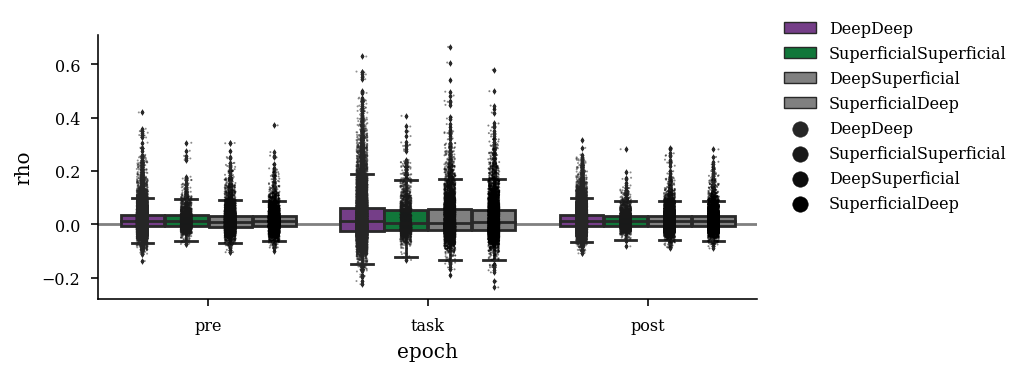

In [50]:
plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(2, 3)))
ax = plt.gca()
sns.boxplot(x="epoch", y="rho",hue="deepSuperficial_combo", data=df,fliersize=1,
                 ax=ax,hue_order=group_colors.keys())
ax.axhline(0,color='grey',zorder=-1000)

sns.stripplot(x="epoch", y="rho",hue="deepSuperficial_combo", data=df,
            size=1,color="k", linewidth=0,ax=ax,
            alpha=.5,dodge=True,hue_order=group_colors.keys(),rasterized=True)

plt.legend(bbox_to_anchor=(.9, 0.01, 0.5, 1.1),frameon=False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig(os.path.join(fig_save_path,'ripple_cross_corr_deep_sup_epoch.pdf'),dpi=300,bbox_inches='tight')


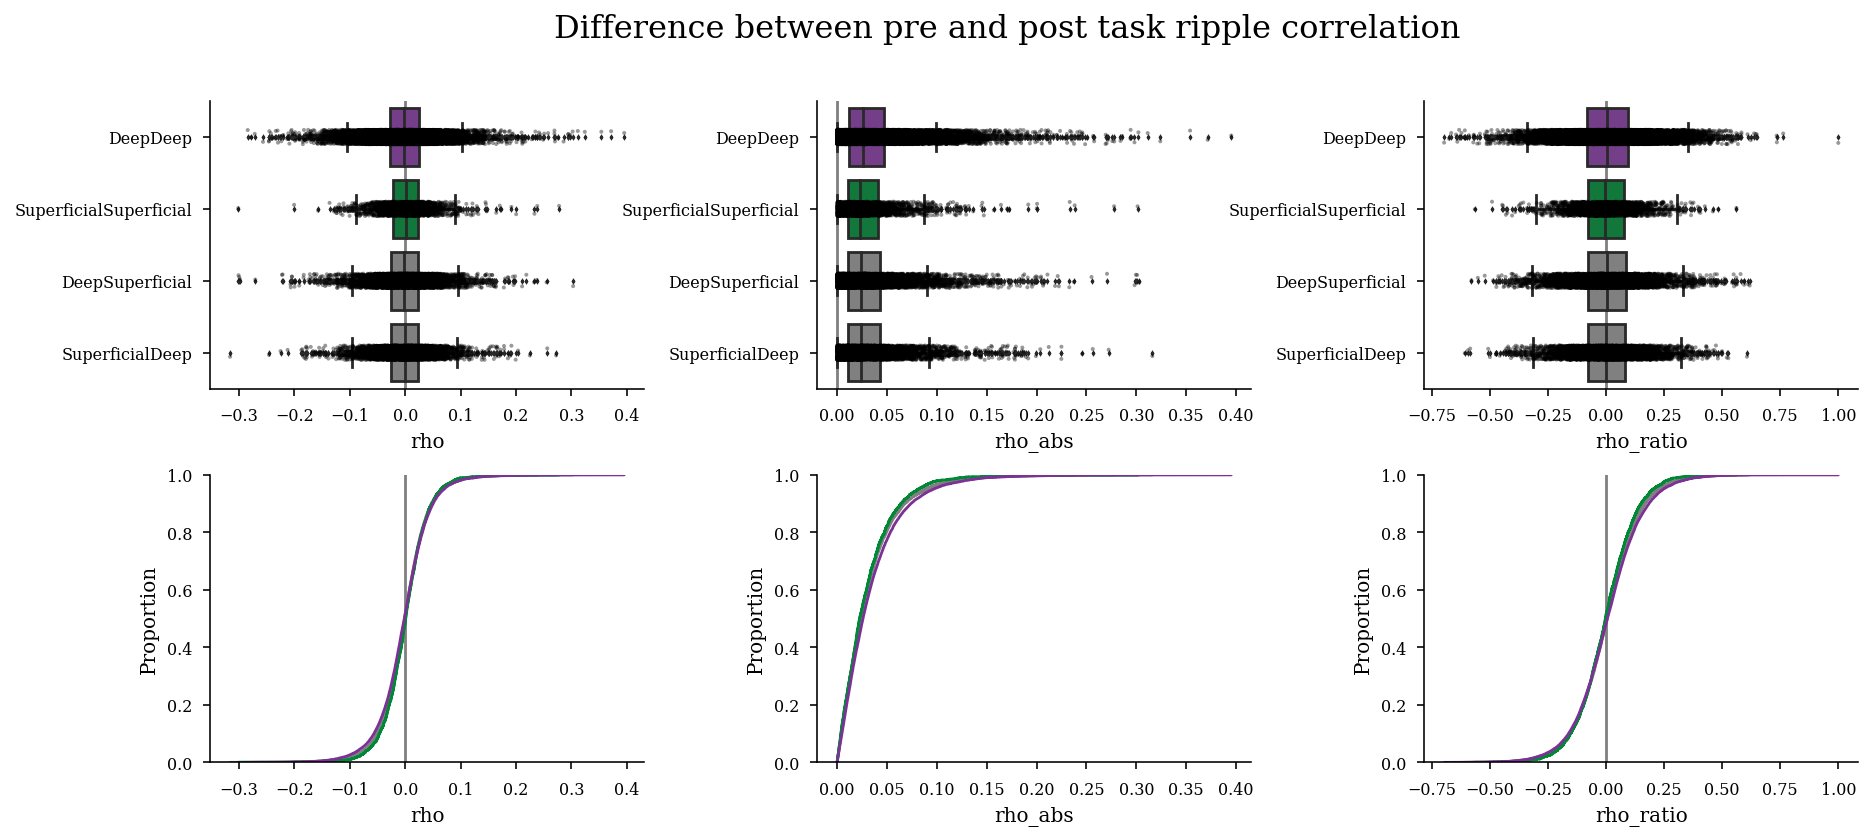

In [51]:
def get_ratio(x1,x2):
    min_val = np.nanmin(np.hstack([x1,x2]))
    if min_val < 0:
        x1 = x1 + np.abs(min_val) + np.finfo(np.float32).eps
        x2 = x2 + np.abs(min_val) + np.finfo(np.float32).eps
    return (x2 - x1) / (x2 + x1)

ratio_df = pd.DataFrame() 
ratio_df['rho'] = df[df.epoch == "pre"].rho.values - df[df.epoch == "post"].rho.values
ratio_df['rho_abs'] = np.abs(ratio_df['rho'])
ratio_df['rho_ratio'] = get_ratio(df[df.epoch == "pre"].rho.values , df[df.epoch == "post"].rho.values)

ratio_df['deepSuperficial_ref'] = df[df.epoch == "pre"].deepSuperficial_ref.values
ratio_df['deepSuperficial_target'] = df[df.epoch == "pre"].deepSuperficial_target.values
ratio_df['deepSuperficial_combo'] = ratio_df['deepSuperficial_ref']+ratio_df['deepSuperficial_target']



def plot_the_box(df,x,y,hue,group_colors,ax):
    sns.boxplot(x=x, y=y, data=df,fliersize=1,
                 ax=ax,hue_order=group_colors.keys(),
                 order=["DeepDeep","SuperficialSuperficial","DeepSuperficial","SuperficialDeep"])

    sns.stripplot(x=x, y=y, data=df,
                size=2,color="k", linewidth=0,ax=ax,
                alpha=.4,dodge=True,hue_order=group_colors.keys(),
                order=["DeepDeep","SuperficialSuperficial","DeepSuperficial","SuperficialDeep"],rasterized=True)
    ax.axvline(0,color='grey',zorder=-1000)

fig, axs = plt.subplots(2,3, figsize=functions.set_size('thesis', fraction=2.5, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.4)
axs = axs.ravel()

group_colors = {"DeepDeep": '#7b3294',
                'SuperficialSuperficial': '#008837',
                'DeepSuperficial': 'grey',
                'SuperficialDeep': 'grey'
                } 

sns.set_palette(sns.color_palette(group_colors.values()))


plot_the_box(ratio_df,"rho","deepSuperficial_combo","deepSuperficial_combo",group_colors,axs[0])
plot_the_box(ratio_df, "rho_abs","deepSuperficial_combo","deepSuperficial_combo",group_colors,axs[1])
plot_the_box(ratio_df, "rho_ratio","deepSuperficial_combo","deepSuperficial_combo",group_colors,axs[2])

sns.ecdfplot(data=ratio_df, x="rho", hue="deepSuperficial_combo",hue_order=group_colors.keys(),ax=axs[3],legend=False)
sns.ecdfplot(data=ratio_df, x="rho_abs", hue="deepSuperficial_combo",hue_order=group_colors.keys(),ax=axs[4],legend=False)
sns.ecdfplot(data=ratio_df, x="rho_ratio", hue="deepSuperficial_combo",hue_order=group_colors.keys(),ax=axs[5],legend=False)

axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

axs[3].axvline(0,color='grey',zorder=-1000)
# axs[4].axvline(0,color='grey',zorder=-1000)
axs[5].axvline(0,color='grey',zorder=-1000)

for i in range(6):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)

fig.suptitle('Difference between pre and post task ripple correlation', fontsize=16)

plt.savefig(os.path.join(fig_save_path,'ripple_cross_corr_deep_sup.pdf'),dpi=300,bbox_inches='tight')
